# Analysis of 2021-2022 CAISO Power Source Data

This data comes from [Kaggle](https://www.kaggle.com/datasets/karatechop/caiso-renewable-energy-data-20212022), and presumably ultimately from CAISO. The units are not labeled, so I am guessing a bit here on what is what. I'm going to do some exploratory analysis, and see if we can do any meaningful forecasting.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
from time import time

In [2]:
sns.set_theme(context='notebook', style='whitegrid')

### Read and preprocess data

Make sure that the date/time columns in the DataFrame are coded as such so that `seaborn`/`matplotlib` don't treat them as strings, which causes major problems when plotting.

It's not clear what the units are for the different energy sources, but based on what is on the [CAISO website](https://www.caiso.com/TodaysOutlook/Pages/default.aspx), I'm guessing they're MW.

In [3]:
power_sources = ['Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports']
other = ['Date', 'Time', 'DateTime', 'Month', 'Year']

In [4]:
df = pd.read_csv('caiso_2021-22.csv', date_parser=['Date', 'Time'])
df.drop(columns=['Other'], inplace=True) # There is hardly any of this, and it just makes the plots look weird
df.Date = pd.to_datetime(df.Date)
df.Time = pd.to_datetime(df.Time)

In [5]:
# Compute the total 
df['Total power'] = df['Solar']
for ps in power_sources[1:]:
    df['Total power'] += df[ps]

In [6]:
df

,Unnamed: 0,Date,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,DateTime,Month,Year,Total power
0,0,2021-09-01,2023-02-05 00:00:00,-34.0,4547.0,928.0,281.0,195.0,168.0,18.0,2263.0,8875.0,1261.0,-186.0,8145.0,2021-09-01 00:00:00,9,2021,26461.0
1,1,2021-09-01,2023-02-05 00:05:00,-34.0,4528.0,929.0,283.0,201.0,169.0,18.0,2262.0,9086.0,1109.0,-13.0,7717.0,2021-09-01 00:05:00,9,2021,26255.0
2,2,2021-09-01,2023-02-05 00:10:00,-34.0,4511.0,929.0,281.0,208.0,146.0,18.0,2263.0,9168.0,985.0,37.0,7553.0,2021-09-01 00:10:00,9,2021,26065.0
3,3,2021-09-01,2023-02-05 00:15:00,-34.0,4514.0,929.0,280.0,214.0,140.0,19.0,2262.0,9167.0,962.0,34.0,7458.0,2021-09-01 00:15:00,9,2021,25945.0
4,4,2021-09-01,2023-02-05 00:20:00,-34.0,4515.0,929.0,281.0,215.0,140.0,18.0,2262.0,9176.0,949.0,35.0,7342.0,2021-09-01 00:20:00,9,2021,25828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105099,283,2022-08-31,2023-02-05 23:35:00,-1.0,2576.0,872.0,339.0,203.0,206.0,4.0,2263.0,16228.0,2679.0,-434.0,8044.0,2022-08-31 23:35:00,8,2022,32979.0
105100,284,2022-08-31,2023-02-05 23:40:00,0.0,2589.0,871.0,340.0,204.0,206.0,5.0,2264.0,16098.0,2687.0,-487.0,8078.0,2022-08-31 23:40:00,8,2022,32855.0
105101,285,2022-08-31,2023-02-05 23:45:00,0.0,2558.0,872.0,339.0,204.0,206.0,5.0,2263.0,16034.0,2636.0,-514.0,8120.0,2022-08-31 23:45:00,8,2022,32723.0
105102,286,2022-08-31,2023-02-05 23:50:00,0.0,2521.0,871.0,339.0,204.0,206.0,5.0,2264.0,15976.0,2642.0,-521.0,8163.0,2022-08-31 23:50:00,8,2022,32670.0


From the description below, we can see that Natural Gas is clearly the largest power source, and also the second most variable after Solar (2nd highest standard deviation).

In [7]:
df.describe()

,Unnamed: 0,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Month,Year,Total power
count,105104.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105104.000000,105104.000000,105092.000000
mean,143.478231,4193.116555,2454.372731,869.873949,287.631047,200.969284,191.277966,12.498525,2076.552973,8614.644778,1457.924219,77.379268,5612.521467,6.526374,2021.665703,26048.762760
std,83.125935,5046.487510,1456.446929,76.966457,45.488711,14.678127,94.729647,4.994506,406.780691,3905.161266,855.182969,572.085363,2963.652848,3.447995,0.471747,4762.813769
min,0.000000,-180.000000,28.000000,474.000000,-278.000000,132.000000,46.000000,-6.000000,446.000000,1494.000000,-494.000000,-1848.000000,-4459.000000,1.000000,2021.000000,15916.000000
25%,71.000000,-33.000000,1200.000000,823.000000,255.000000,195.000000,153.000000,9.000000,2250.000000,5692.000000,878.000000,-234.000000,3395.000000,4.000000,2021.000000,22661.000000
50%,143.000000,170.000000,2211.000000,878.000000,288.000000,204.000000,190.000000,14.000000,2264.000000,8116.000000,1279.000000,3.000000,6208.000000,7.000000,2022.000000,25121.500000
75%,215.000000,9391.000000,3649.000000,903.000000,320.000000,211.000000,226.000000,17.000000,2268.000000,10828.000000,1908.000000,319.000000,7999.000000,10.000000,2022.000000,27983.250000
max,287.000000,14288.000000,6429.000000,1134.000000,412.000000,242.000000,3316.000000,91.000000,2287.000000,25441.000000,4556.000000,3053.000000,11587.000000,12.000000,2022.000000,46679.000000


## Exploratory Data Analysis

This dataset comes in 5 minute intervals spanning a full year. That is >100k samples, which is difficult to visualize meaningfully all at once. Furthermore, there are at least 2 meaningful periods of variation in this dataset: daily and annually. For these reasons, we'll make 2 different plots, one showing the daily average power generation over the course of the full year, and one showing hourly power generation over one day, averaging over every day of the dataset.

If we do this for only the Solar power data, we see the following figures

<AxesSubplot: xlabel='Date', ylabel='Solar'>

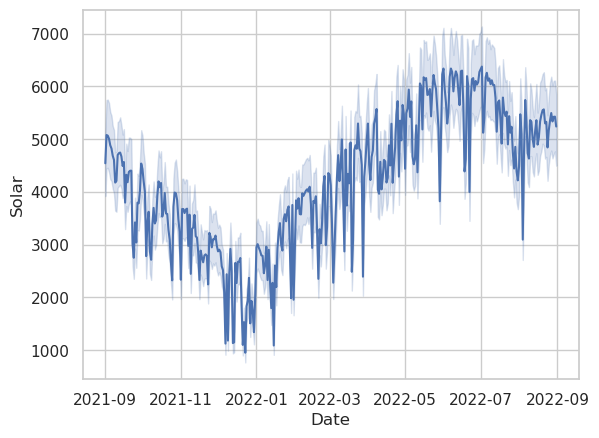

In [8]:
sns.lineplot(data=df, x='Date', y='Solar')

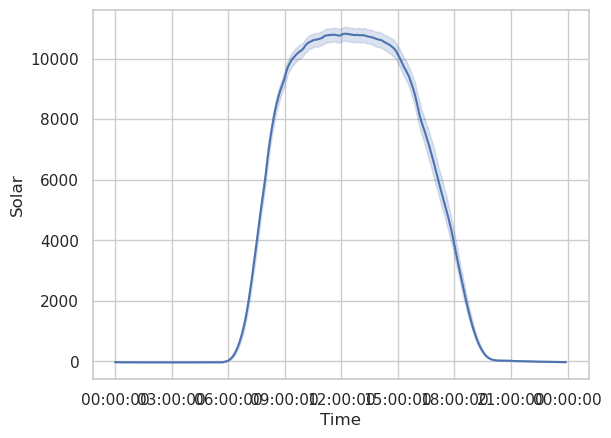

In [9]:
ax = sns.lineplot(data=df, x='Time', y='Solar')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

The curves are almost exactly what we should expect. The annual curve peaks in late June at the summer solstice, and has a trough in late December during the winter solstice. The light blue shaded region shows the 95% inner quantile range.

In order to make more plots easily with Seaborn, we need to convert the DataFrame from wide to long format.

In [10]:
df_long = df.drop(columns=['Unnamed: 0'])\
    .melt(id_vars=['Date', 'Time', 'DateTime', 'Month', 'Year'],
          var_name='Source',
          value_name='Power (MW)')
df_long

,Date,Time,DateTime,Month,Year,Source,Power (MW)
0,2021-09-01,2023-02-05 00:00:00,2021-09-01 00:00:00,9,2021,Solar,-34.0
1,2021-09-01,2023-02-05 00:05:00,2021-09-01 00:05:00,9,2021,Solar,-34.0
2,2021-09-01,2023-02-05 00:10:00,2021-09-01 00:10:00,9,2021,Solar,-34.0
3,2021-09-01,2023-02-05 00:15:00,2021-09-01 00:15:00,9,2021,Solar,-34.0
4,2021-09-01,2023-02-05 00:20:00,2021-09-01 00:20:00,9,2021,Solar,-34.0
...,...,...,...,...,...,...,...
1366347,2022-08-31,2023-02-05 23:35:00,2022-08-31 23:35:00,8,2022,Total power,32979.0
1366348,2022-08-31,2023-02-05 23:40:00,2022-08-31 23:40:00,8,2022,Total power,32855.0
1366349,2022-08-31,2023-02-05 23:45:00,2022-08-31 23:45:00,8,2022,Total power,32723.0
1366350,2022-08-31,2023-02-05 23:50:00,2022-08-31 23:50:00,8,2022,Total power,32670.0


Seaborn will order the line colors based on the order in which they show up in the DataFrame. This is fine, but I want them to be listed in the legend in the same order as they will appear visually on the plot.

In [11]:
argsort = df_long.groupby('Source').mean(numeric_only=True)['Power (MW)']\
            .argsort().values[::-1]
hue_order = np.array(
    df_long.groupby('Source').mean(numeric_only=True)\
        ['Power (MW)'][argsort].index
    )
# pal = np.concatenate(([[0,0,0]], np.array(sns.color_palette('Paired', len(hue_order)-1))))
pal = np.array(sns.color_palette('husl', len(hue_order)))[argsort]
pal[0] = np.array([0,0,0])

Next we'll make the same plots as above, but this time for all power sources. We can do this easily with the long-form DataFrame and Seaborn.

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


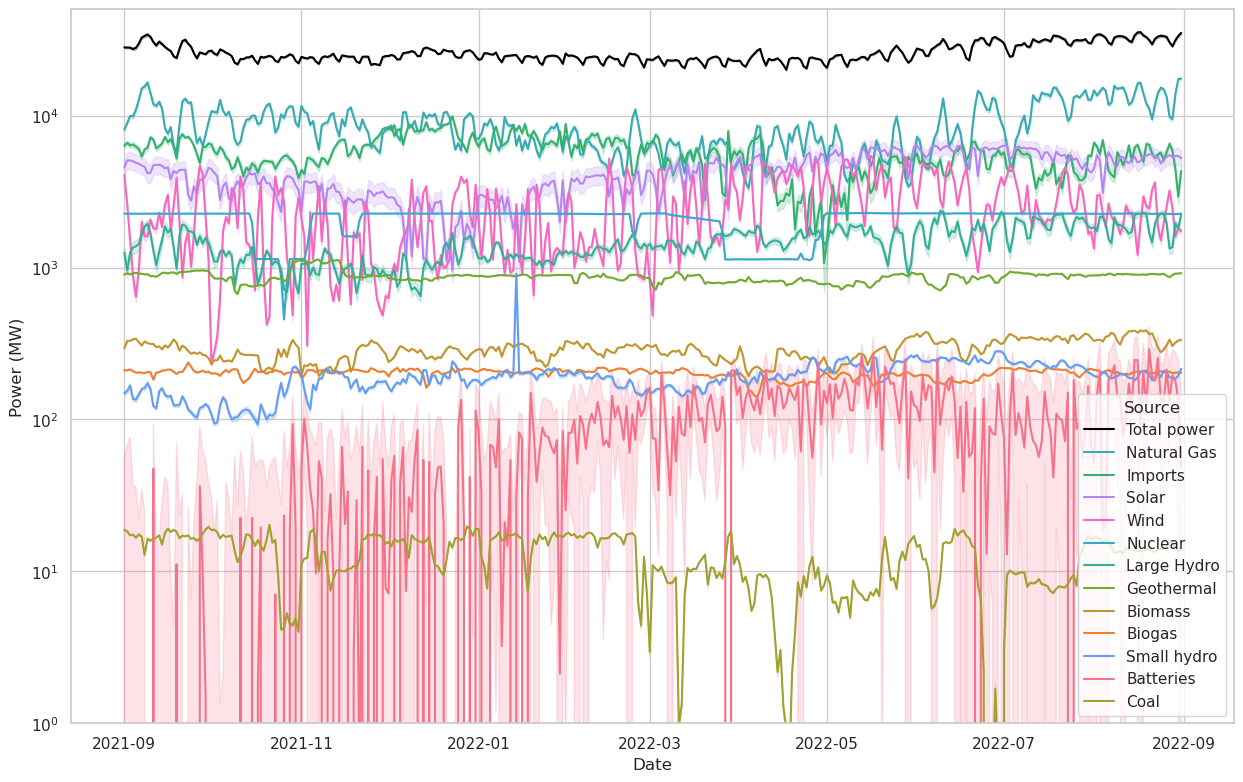

In [13]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Date',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.set(yscale='log')
ax.set_ylim([1,5e4])
plt.show()

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


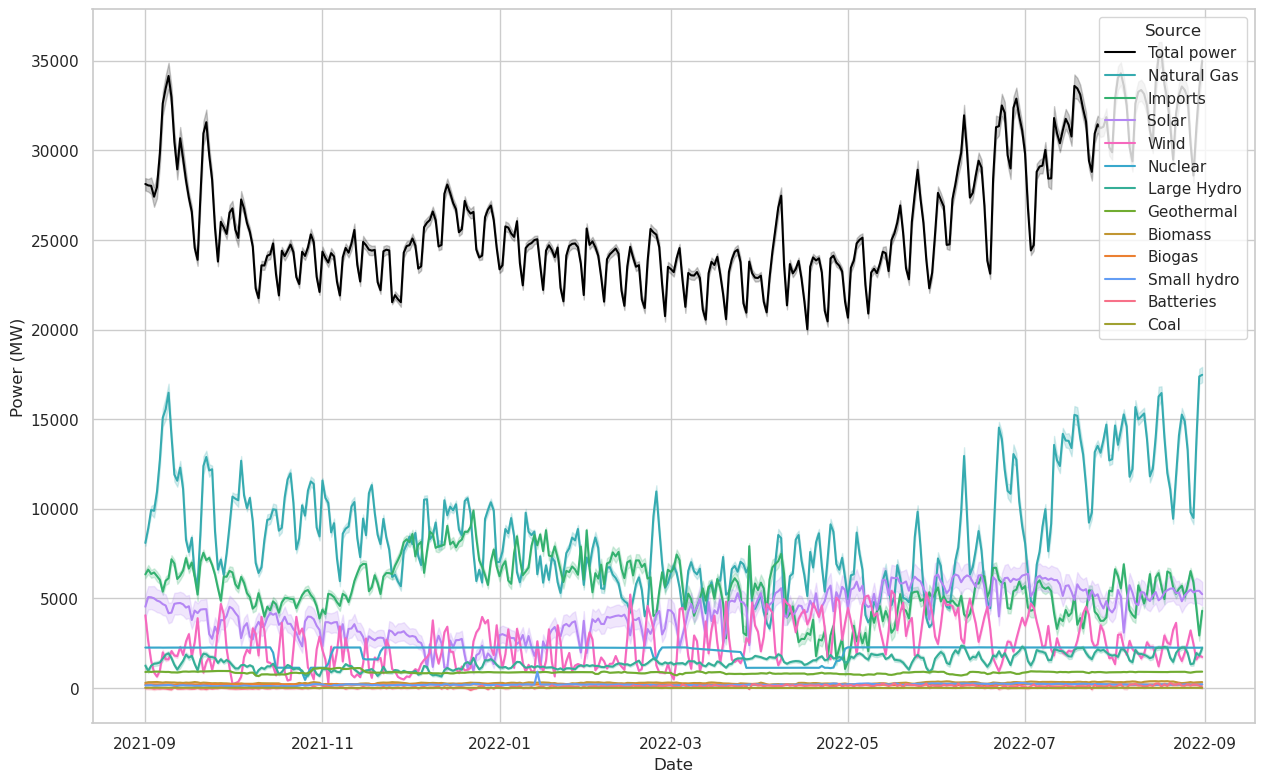

In [38]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Date',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
plt.show()

There are a number of interesting features happening in the two figures above.
- A weeklong variable period is apparent in the Total Power curve. January 1st 2022 was a Saturday and also lines up with one of the troughs, which indicates to me that weekends generally put substantially less load on the power system.
- In the linear plot, we can see that the Total Power drawn is generally higher in the summer and lower in the winter, although there is a notable increase in power draw around Christmastime. Christmas lights? Or perhaps it was just cold.
- Unsurprisingly, nuclear power output is generally extremely steady, although we can see that it did drop off a few times.
- We can again see the seasonal variability of solar power, probably more clearly in the linear plot than the log.
- On a day-to-day basis, wind power is extremely variable, more so than solar.
- California imports more power in the winter than summer. I would guess this may be because electricity gets more expensive in the summer, and therefore harder to import.
- Biomass, biogas, small hydro, and batteries play a pretty small role.
- There is virtually no coal power in the system. That's because there is only one 63 MW coal plant operating in the state of California, in Trona.

Now let's take a look at the hourly data.

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


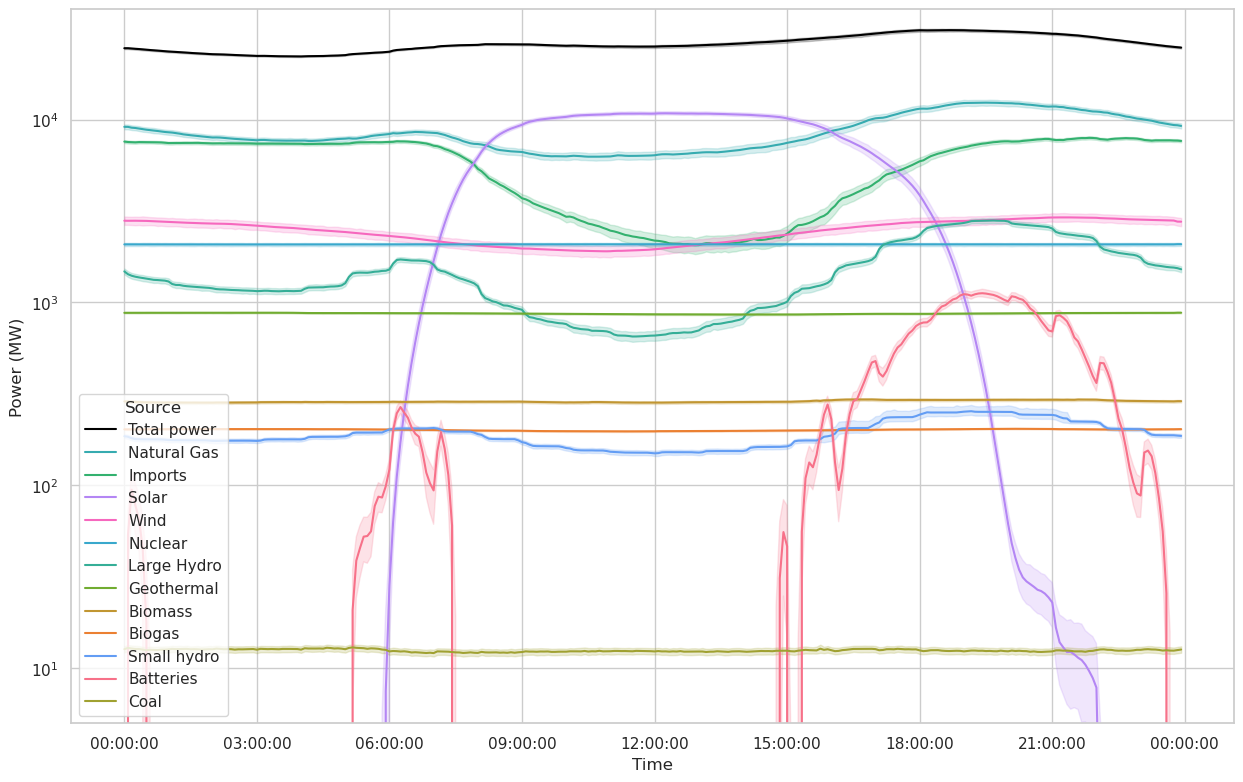

In [59]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Time',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.set(yscale='log')
ax.set_ylim([5,4e4])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


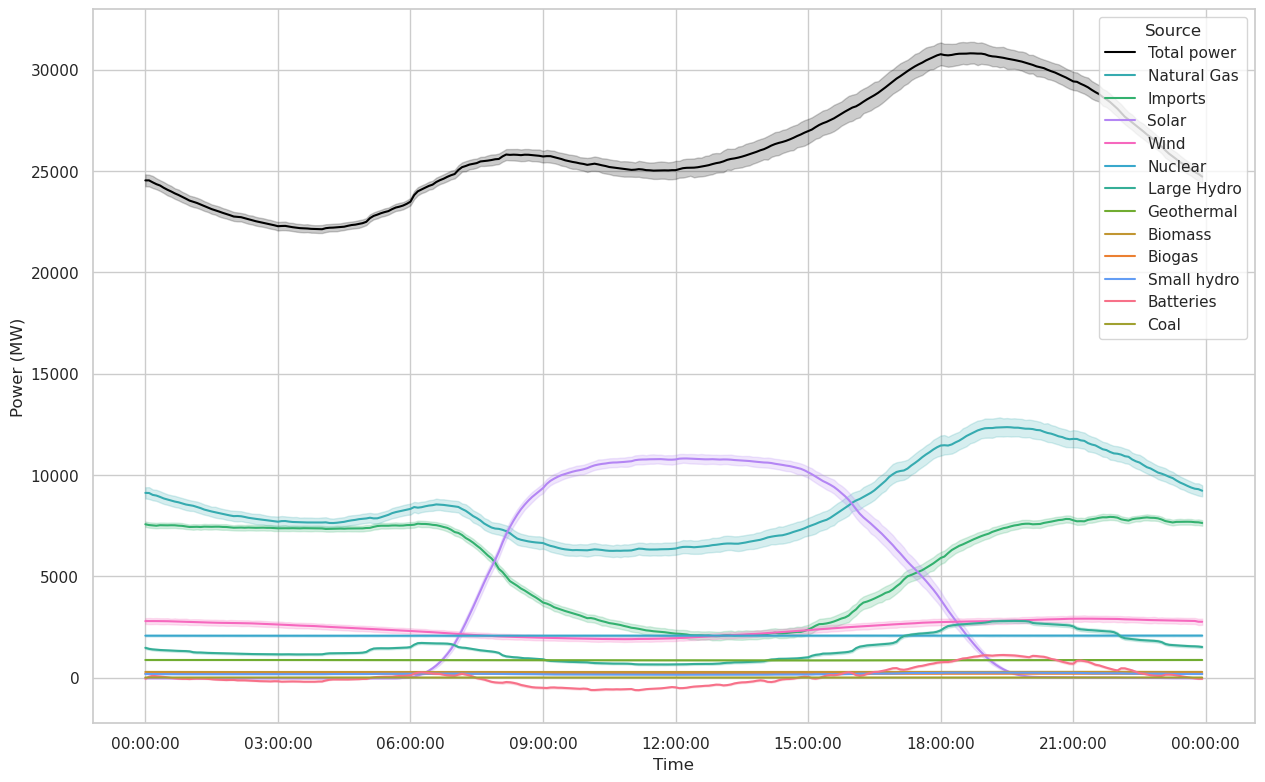

In [39]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Time',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

Again we can make a few interesting observations.
- Although they make up only a small part of CAISO's power capacity, batteries are playing a nontrivial role at certain times of day, particularly in the evening. We can also see the batteries charging during the day in the linear plot (where the curve goes negative).
- The solar power curve has two "tails". I don't know what is causing them, but my hypothesis of what is has two components:
  - California is a long state N/S, and summer is the part of the year where the sun is up latest into the evening. During the summer, the evening terminator is mostly perpendicular to the length of the state, meaning that there should be a gradual dropoff in solar power as it gets dark from south to north. That explains the fact that there is at least one bump.
  - There are two bumps instead of one because of daylight savings time.
  - This does not occur in the morning because on summer mornings, the terminator faces the opposite direction and so all parts of the state start receiving solar power at about the same time.
- Wind power does indeed see variation complementary to solar power as advertised, but it is a much smaller source than solar and therefore is not able to offset much of the solar variability.

For the last plots in this section, I'm going to separate sources into dispatchable and variable. Dispatchable resources are those that can be adjusted during the day to compensate for uncontrollable variability in other sources and demand. In practice, I am separating sources into these two categories based on whether they appear to have controllable daily variation in the plot above. The dispatchable resources that seem to have this:
- Natural Gas
- Imports
- Large Hydro
- Small Hydro
- Batteries
- (Theoretically coal would go here as well, but it's too small for me to see evidence of daily variation.)

In principle, some of the other resources can be ramped up or down, but I would guess that they aren't because they are smaller and more distributed, and may not be technically set up to be ramped on demand.

In [12]:
df_long = df_long[df_long['Source']!='Total power']
dispatchable = ['Natural Gas', 'Imports', 'Large Hydro', 'Small hydro', 'Batteries', 'Coal']
variable = ['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Nuclear']
df_long['Dispatchable'] = df_long['Source'].apply(lambda x: x in dispatchable)

/tmp/ipykernel_1387/2591602897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['Dispatchable'] = df_long['Source'].apply(lambda x: x in dispatchable)


In [13]:
df_dispatchable = df_long.groupby(by=['DateTime', 'Time', 'Date', 'Dispatchable']).sum()
df_dispatchable.reset_index(level=3, inplace=True)

/tmp/ipykernel_1387/4263355843.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dispatchable = df_long.groupby(by=['DateTime', 'Time', 'Date', 'Dispatchable']).sum()


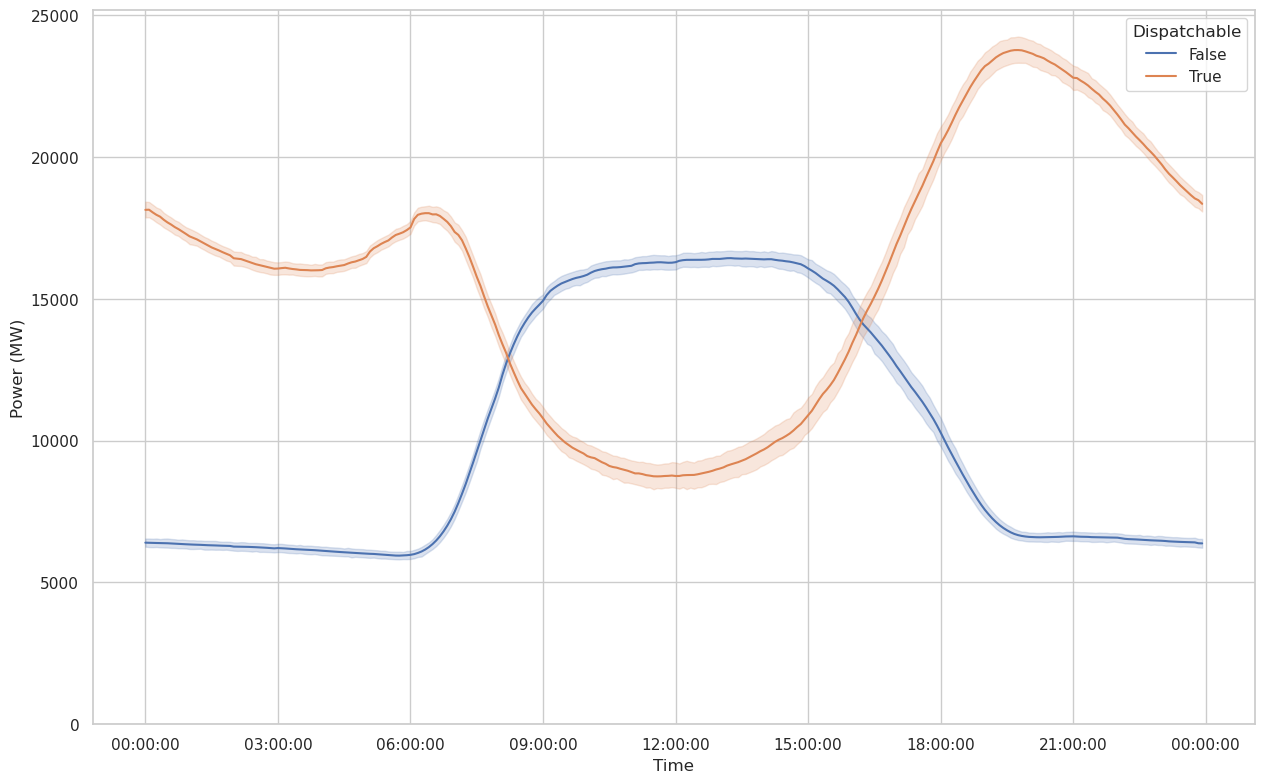

In [71]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(data=df_dispatchable, x='Time', y='Power (MW)', hue='Dispatchable')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

(0.0, 26955.196124131944)

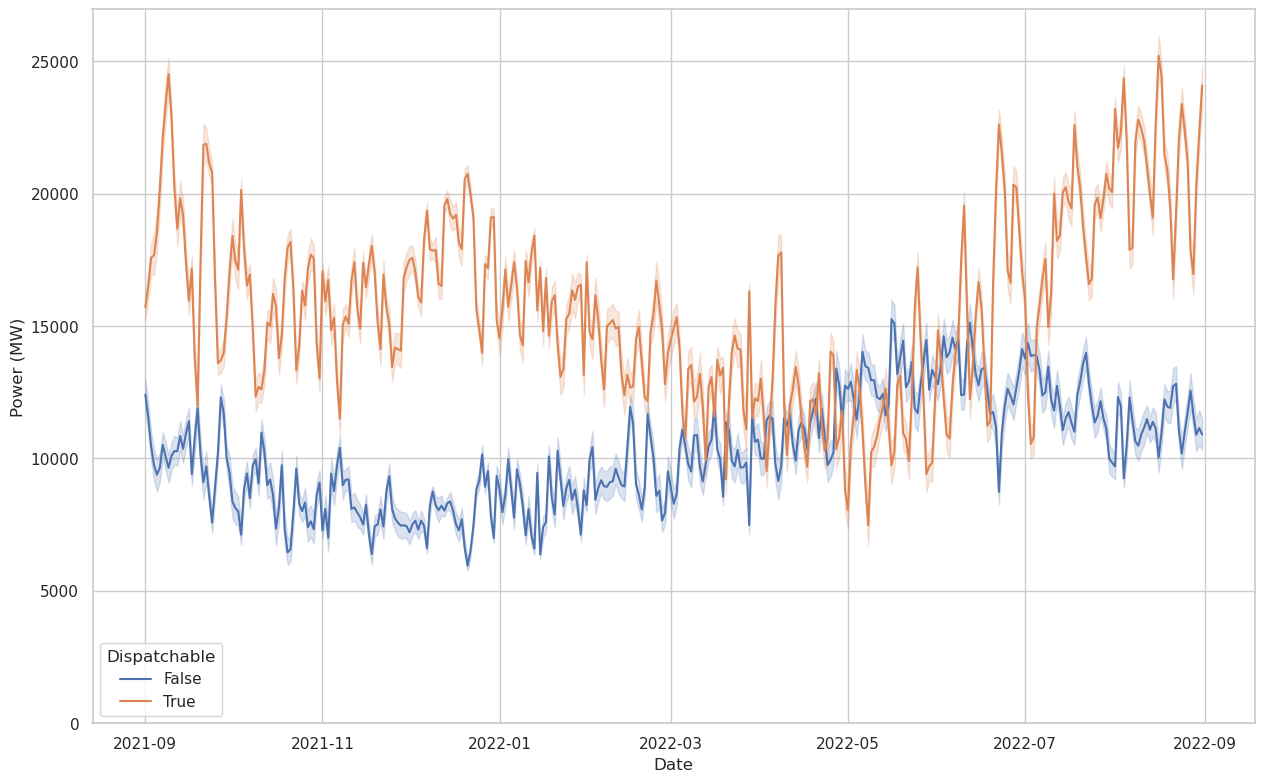

In [75]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(data=df_dispatchable, x='Date', y='Power (MW)', hue='Dispatchable')
ax.set_ylim([0, ax.get_ylim()[1]])

There's not quite as much to see here as in the previous plots, except that the duck curve is alive and well in the hourly plot. The daily plot is dominated by random variation and the seasonal variation of solar power.

## Time-series Modeling

Let's see if we can extract any utility (haha) from time-series analysis of this data. First we'll try an ARIMA analysis.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

We have a full year of 5-minute samples available, which translates to 105,104 samples. This (empirially) is too many to fit on my laptop, so I'm going to downsample the data to hourly. In the real world, 5-minute predictions may be useful, but we're going to make do with 1-hr predictions for now.

In [13]:
df['Hour'] = df.DateTime.apply(datetime.datetime.fromisoformat).dt.hour
df_hourly = df.groupby(by=['Date', 'Hour']).mean()
df_hourly.dropna(inplace=True) # Daylight savings causes a NaN

/tmp/ipykernel_1618/3178447348.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hourly = df.groupby(by=['Date', 'Hour']).mean()


We're going to try to predict the total amount of power from dispatchable resources required at any point in time. This is similar to what a real power company or ISO has to do in real time: tune the dispatchable power sources to cover the difference between variable supply and demand at all times.

Since the amount of variable resource supply affects how much dispatchable power will be needed, it is reasonable to look for relationships between previous values of variable power output and the current amount of dispatchable power. Below I create a series of plots showing the relationship between a series of lagged variable power samples and dispatchable power.

In [14]:
df_hourly['Dispatchable'] = np.sum([df_hourly[s] for s in dispatchable], axis=0)
df_hourly['Variable'] = np.sum([df_hourly[s] for s in variable], axis=0)
for i in range(1, 10):
    df_hourly['Variable.L{}'.format(i)] = np.roll(df_hourly['Variable'], i)

NameError: name 'dispatchable' is not defined

First let's take a look at the autocorrelation and partial autocorrelation functions. These will help us decide what kind of model is most appropriate.

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


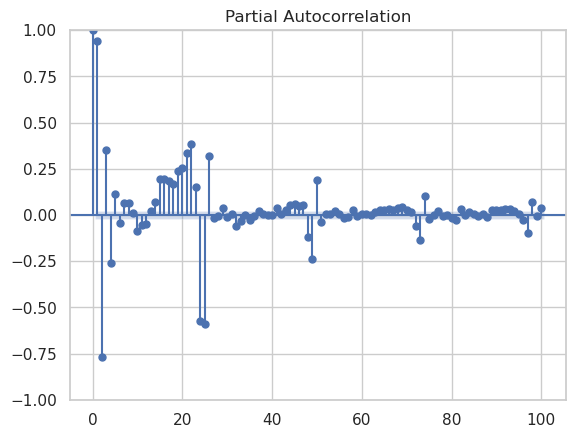

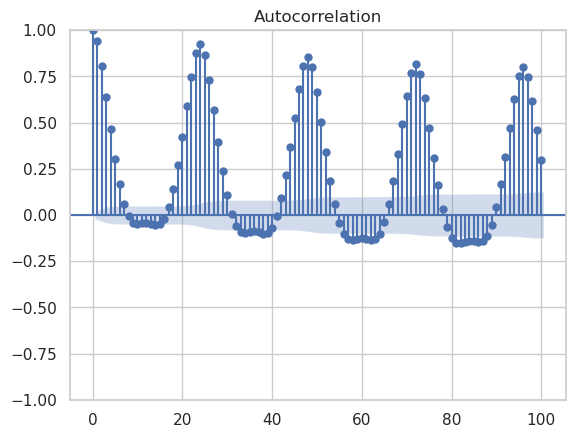

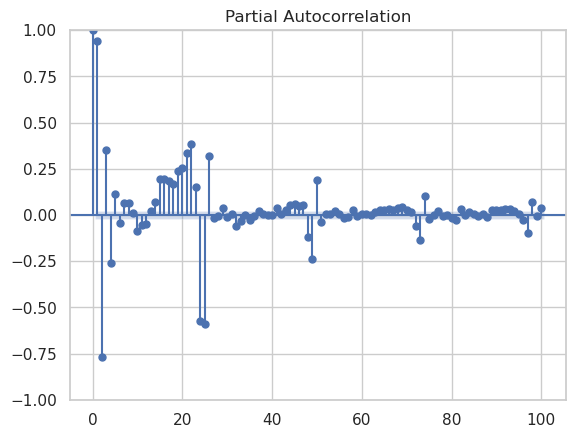

In [24]:
# I don't know if it's a bug in statsmodels or what, but this makes two copies of one or both plots for some reason
plot_acf(df_hourly['Dispatchable'], lags=100)
plot_pacf(df_hourly['Dispatchable'], lags=100)

We see pretty clear evidence of a daily pattern in the autocorrelation function. The partial autocorrelation function suggests that there is meaningful information to be extracted up to lags of about 24, which makes sense since this data is taken over a 24 hour daily period. Unsurprisingly, we see evidence of "seasonality", where in this case a season corresponds to a 24 hr day. This suggests that an ARIMA model of ARIMA(24, 0, 0)x(1, 0, 0, 24) could be appropriate. However, this is way too many lags to fit in a reasonable amount of time, so we'll just have to see how many we can do before I run out of computation power or they stop adding reasonable predictive power.

We should also look at the real-time relationship between variable and dispatchable resources. Clearly there is a strong relationship, but if we are trying to predict future values of dispatchable power, we will only have access to past values of variable power. Therefore, we need to take at least one lag to make this realistic.

<AxesSubplot: xlabel='Dispatchable', ylabel='Variable'>

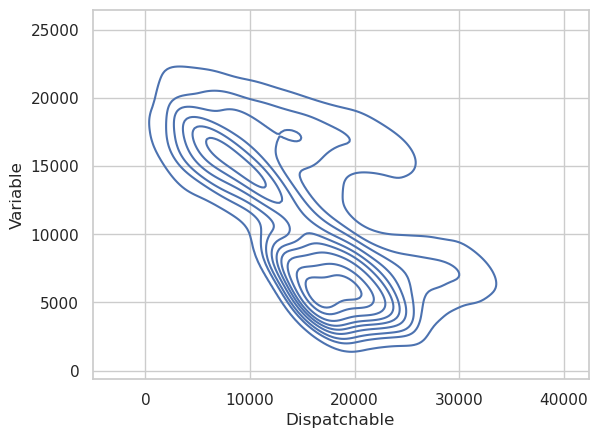

In [27]:
sns.kdeplot(data=df_hourly, x='Dispatchable', y='Variable')

<AxesSubplot: xlabel='Dispatchable', ylabel='Variable.L1'>

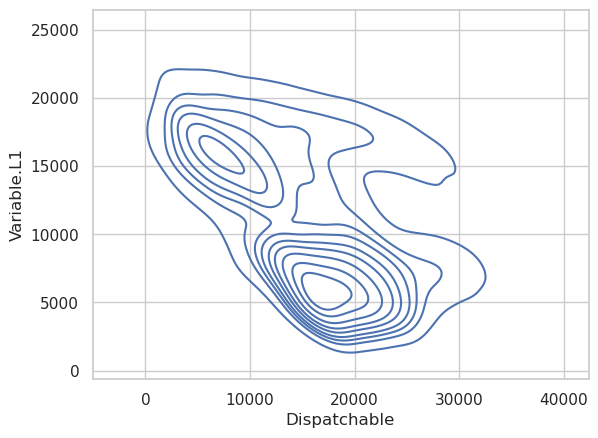

In [28]:
sns.kdeplot(data=df_hourly[1:], x='Dispatchable', y='Variable.L1')

<AxesSubplot: xlabel='Dispatchable', ylabel='Variable.L2'>

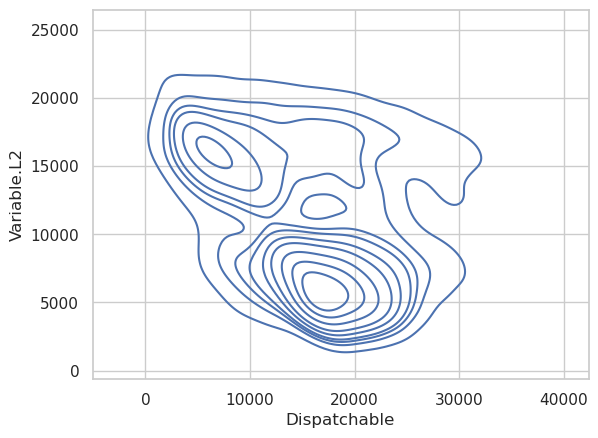

In [29]:
sns.kdeplot(data=df_hourly[1:], x='Dispatchable', y='Variable.L2')

<AxesSubplot: xlabel='Dispatchable', ylabel='Variable.L3'>

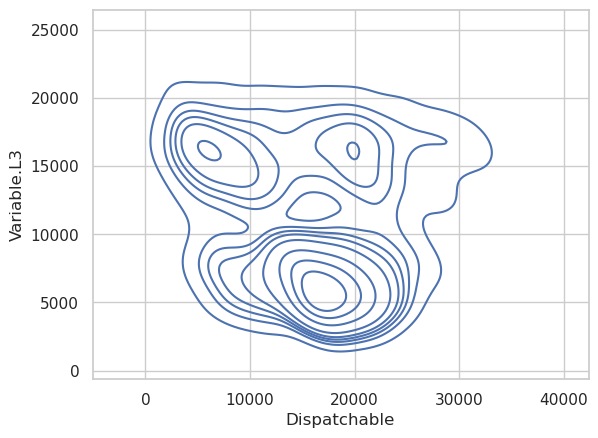

In [30]:
sns.kdeplot(data=df_hourly[1:], x='Dispatchable', y='Variable.L3')

<AxesSubplot: xlabel='Dispatchable', ylabel='Variable.L9'>

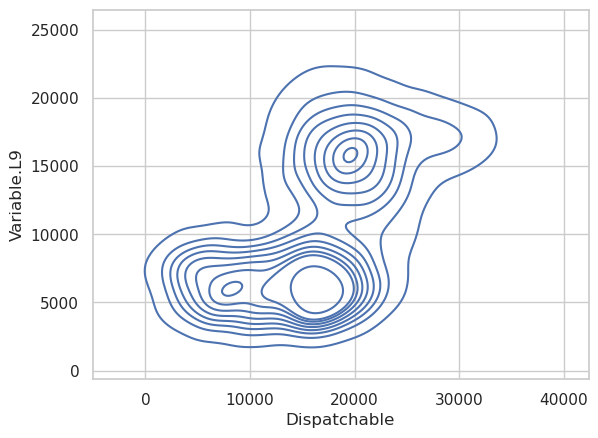

In [31]:
sns.kdeplot(data=df_hourly[9:], x='Dispatchable', y='Variable.L9')

The first two variable lags have a reasonably strong relationship with the dispatchable power output, but by the time we get to the third lag, there isn't much left. The ninth lag also shows essentially no relationship between the two, so we'll limit the model to the first two lags of variable power output.

Given the results of the autocorrelation plots and the Variable vs. Dispatchable plots above, let's build a series of models with 1 and 2 Variable source lags, building up the number of autocorrelated lags as far as we reasonably can. We'll also include one 24-hr seasonal term.

In [17]:
# Baseline, no seasonal autocorrelation, no exogenous variables
model_0_1_0 = ARIMA(endog=df_hourly['Dispatchable'], order=(1,0,0))
res_0_1_0 = model_0_1_0.fit()
print(res_0_1_0.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Dispatchable   No. Observations:                 8759
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -79321.828
Date:                Sun, 05 Feb 2023   AIC                         158649.656
Time:                        10:16:15   BIC                         158670.890
Sample:                             0   HQIC                        158656.891
                               - 8759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.597e+04    420.877     37.936      0.000    1.51e+04    1.68e+04
ar.L1          0.9439      0.004    239.155      0.000       0.936       0.952
sigma2        4.3e+06   5.13e+04     83.832      0.0

In [18]:
# Baseline, no autoregression, 24-hr "seasonal" autoregression
model_0_0_1 = ARIMA(endog=df_hourly['Dispatchable'], order=(0,0,0), seasonal_order=(1,0,0,24))
res_0_0_1 = model_0_0_1.fit()
print(res_0_0_1.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Dispatchable   No. Observations:                 8759
Model:             ARIMA(1, 0, 0, 24)   Log Likelihood              -80386.596
Date:                Sun, 05 Feb 2023   AIC                         160779.192
Time:                        10:16:20   BIC                         160800.425
Sample:                             0   HQIC                        160786.427
                               - 8759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.597e+04    358.556     44.530      0.000    1.53e+04    1.67e+04
ar.S.L24       0.9298      0.004    236.051      0.000       0.922       0.938
sigma2      5.462e+06   6.02e+04     90.769      0.0

In [26]:
# Baseline with both autocorrelation and seasonal autocorrelation
model_0_1_1 = ARIMA(endog=df_hourly['Dispatchable'], order=(1,0,0), seasonal_order=(1, 0, 0, 24))
res_0_1_1 = model_0_1_1.fit()
print(res_0_1_1.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -69337.252
Date:                          Sun, 05 Feb 2023   AIC                         138682.504
Time:                                  10:05:54   BIC                         138710.815
Sample:                                       0   HQIC                        138692.150
                                         - 8759                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.597e+04   1.48e-11   1.08e+15      0.000     1.6e+04     1.6e+04
ar.L1          1.0000    1.6e-05   6.23e+04      0.

In [19]:
# AR(1)xSAR(1)xVar.L1
model_1_1 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1']], order=(1,0,0), seasonal_order=(1, 0, 0, 24))
res_1_1 = model_1_1.fit()
print(res_1_1.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -69250.928
Date:                          Sun, 05 Feb 2023   AIC                         138511.856
Time:                                  10:17:19   BIC                         138547.245
Sample:                                       0   HQIC                        138523.915
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.301e+04   8.65e-09   2.66e+12      0.000     2.3e+04     2.3e+04
Variable.L1    -0.4229      0.000   -898.260    

`ar.L1 == 1` is a random walk, where the most likely next value is the current value. On top of that, we have a strong relationship between the next value and the sample 24 hours ago, which is also close to a random walk with a 24 hr period. Finally, we also see that there is an inverse relationship between the forecasted dispatchable power output and the previous variable power output, as expected. We'll use the information criteria in the upper right to choose our model. 

In [32]:
# AR(2)xSAR(1)xVar.L1
model_1_2 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 24))
res_1_2 = model_1_2.fit()
print(res_1_2.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68125.930
Date:                          Sun, 05 Feb 2023   AIC                         136263.861
Time:                                  07:26:56   BIC                         136306.328
Sample:                                       0   HQIC                        136278.331
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.301e+04   1527.241     15.066      0.000       2e+04     2.6e+04
Variable.L1     0.0347      0.013      2.749    

The parameters have changed a bit now that we've added the extra lag. Besides the fit taking quite a bit longer, we now have a negative coefficient for the `L2` term and a positive coefficient for the `L1` term. This corresponds roughly to making a linear extrapolation from the previous two sample points. The coefficient of the `Variable.L1` term has also nearly disappeared, but it is still quite statistically significant.

In [20]:
# AR(3)xSAR(1)xVar.L1
model_1_3 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1']], order=(3, 0, 0), seasonal_order=(1, 0, 0, 24))
res_1_3 = model_1_3.fit()
print(res_1_3.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68048.912
Date:                          Sun, 05 Feb 2023   AIC                         136111.824
Time:                                  10:20:22   BIC                         136161.369
Sample:                                       0   HQIC                        136128.706
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.301e+04   1802.777     12.763      0.000    1.95e+04    2.65e+04
Variable.L1     0.1533      0.016      9.590    

In [17]:
# AR(4)xSAR(1)xVar.L1
model_1_4 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1']], order=(4, 0, 0), seasonal_order=(1, 0, 0, 24))
res_1_4 = model_1_4.fit()
print(res_1_4.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(4, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68061.618
Date:                          Sun, 05 Feb 2023   AIC                         136139.236
Time:                                  07:51:19   BIC                         136195.859
Sample:                                       0   HQIC                        136158.529
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.301e+04   2668.673      8.622      0.000    1.78e+04    2.82e+04
Variable.L1     0.2007      0.017     12.149    

Non-convergence means that we are done adding terms, and `model_1_3` is the best we are going to do with only `Variable.L1`.

In [24]:
# AR(1)xSAR(1)xVar.L1xVar.L2
model_2_1 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1','Variable.L2']], order=(1, 0, 0), seasonal_order=(1, 0, 0, 24))
res_2_1 = model_2_1.fit()
print(res_2_1.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68898.499
Date:                          Sun, 05 Feb 2023   AIC                         137808.998
Time:                                  10:28:14   BIC                         137851.465
Sample:                                       0   HQIC                        137823.468
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         2.21e+04   2.71e-08   8.16e+11      0.000    2.21e+04    2.21e+04
Variable.L1    -0.3860      0.009    -42.275    

In [18]:
# AR(2)xSAR(1)xVar.L1xVar.L2
model_2_2 = ARIMA(endog=df_hourly['Dispatchable'], exog=df_hourly[['Variable.L1','Variable.L2']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 24))
res_2_2 = model_2_2.fit()
print(res_2_2.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68275.361
Date:                          Sun, 05 Feb 2023   AIC                         136564.722
Time:                                  08:09:44   BIC                         136614.267
Sample:                                       0   HQIC                        136581.604
                                         - 8759                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         2.21e+04   3.35e-08   6.59e+11      0.000    2.21e+04    2.21e+04
Variable.L1     0.0411      0.010      4.307    

In [19]:
# AR(4)xSAR(1)
model_0_4 = ARIMA(endog=df_hourly['Dispatchable'], order=(4, 0, 0), seasonal_order=(1, 0, 0, 24))
res_0_4 = model_0_4.fit()
print(res_0_4.summary())

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                     Dispatchable   No. Observations:                 8759
Model:             ARIMA(4, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -68073.396
Date:                          Sun, 05 Feb 2023   AIC                         136160.792
Time:                                  08:14:48   BIC                         136210.337
Sample:                                       0   HQIC                        136177.673
                                         - 8759                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.597e+04   1329.281     12.011      0.000    1.34e+04    1.86e+04
ar.L1          1.4725      0.008    185.271      0.

We can plot a barchart of the AIC values for each model, which will help us decide which is optimal.

In [28]:
AICs = pd.DataFrame(
    {
        'AIC':[158649.656, 160779.192, 138682.504,
               138511.856, 136263.861, 136111.824,
               137808.998, 136564.722, 136160.792],
        'Model': ['AR(1)', 'SAR(1)', 'AR(1)xSAR(1)',
                  'AR(1)xSAR(1)xVar.L1', 'AR(2)xSAR(1)xVar.L1', 'AR(3)xSAR(1)xVar.L1',
                  'AR(1)xSAR(1)xVar.L1xVar.L2', 'AR(2)xSAR(1)xVar.L1xVar.L2', 'AR(4)xSAR(1)']
    }
)
AICs['Relative AIC'] = AICs['AIC'] - np.min(AICs['AIC'])

<AxesSubplot: xlabel='Relative AIC', ylabel='Model'>

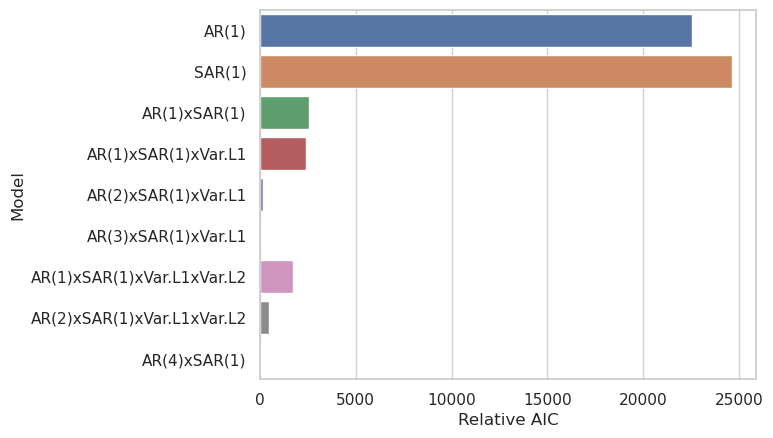

In [29]:
sns.barplot(data=AICs, x='Relative AIC', y='Model')

The Relative AIC is just the difference between the given model's AIC and the lowest AIC amongst all models. It is a bit hard to see, but the `AR(3)xSAR(1)xVar.L1` model has the lowest AIC, followed closely by the `AR(4)xSAR(1)` model. The fact that these are so close, coupled with the fact that including `Var.L1` does seem to improve things (see `AR(1)xSAR(1)` vs. `AR(1)xSAR(1)xVar.L1`), suggests that a `AR(4)xSAR(1)xVar.L1` model would likely perform even better if it had converged. Interestingly, adding the second `Variable` resource lag (`Var.L2`) seems to make things worse at `AR(2)`.

Next we'll look directly at some predictions and residuals. First, we'll make a plot showing the predicted power vs the actual dispatchable power over the course of the year.

In [22]:
preds = pd.DataFrame(res_1_3.predict()).rename(columns={'predicted_mean':'Predicted Power (MW)'})
preds['Power (MW)'] = df_hourly['Dispatchable']
preds['Residual (MW)'] = preds['Predicted Power (MW)'] - preds['Power (MW)']

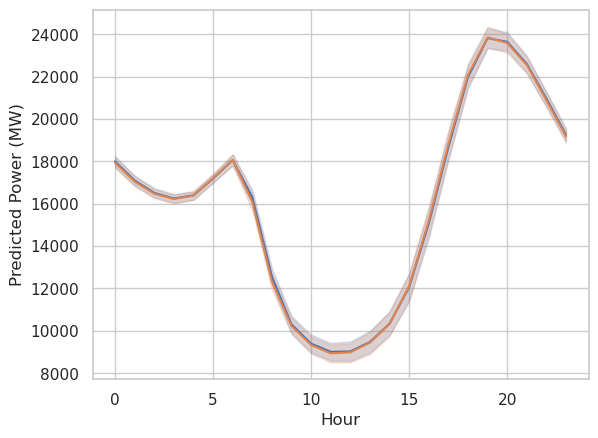

In [21]:
ax = sns.lineplot(data=preds, x='Hour', y='Predicted Power (MW)')
ax = sns.lineplot(ax=ax, data=preds, x='Hour', y='Power (MW)')

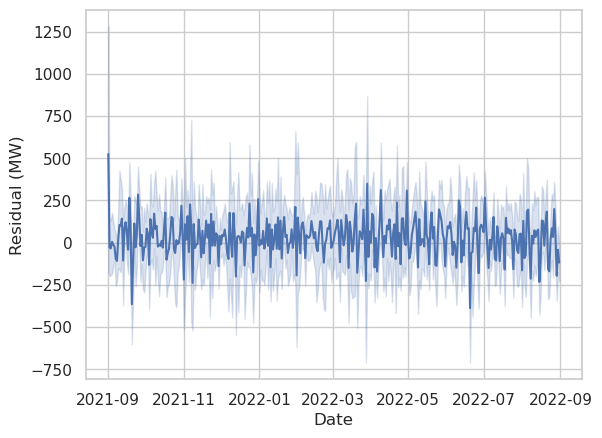

In [22]:
ax = sns.lineplot(data=preds, x='Date', y='Residual (MW)')

The residuals are small enough that they don't noticeably show up on the first plot. By eye it looks like the residuals may be higher in the summer than in the winter, but that is hard to say. That wouldn't surprise me very much, since solar power is much stronger in the summer and makes up the largest share of the variable resources. Weather effects, which should be a large contributor to solar variablity, would have a bigger effect on the overall market during periods with greater sunshine.

Next we'll look at some plots of 3 arbitrary days of data with different models, comparing the actual and predicted dispatchable power output. First we'll look at the final chosen model.

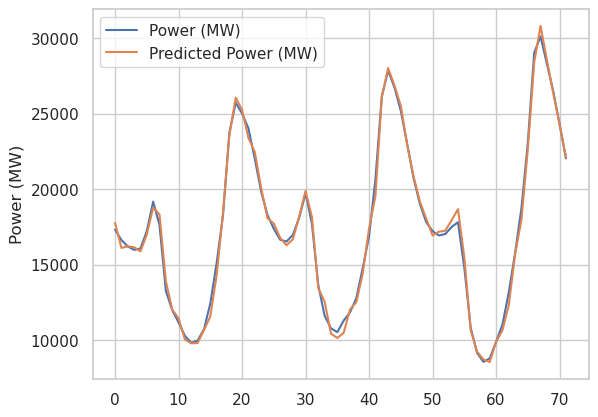

In [23]:
ax = sns.lineplot(x=range(72), y=preds[24:96]['Power (MW)'], label='Power (MW)')
ax = sns.lineplot(ax=ax, x=range(72), y=res_1_3.predict()[24:96], label='Predicted Power (MW)')

We see excellent agreement in general, as expected.

Next we'll look at the `AR(1)` model, a.k.a. one autoregressive lag, no seasonal component, and no dependence on prior variable resource output.

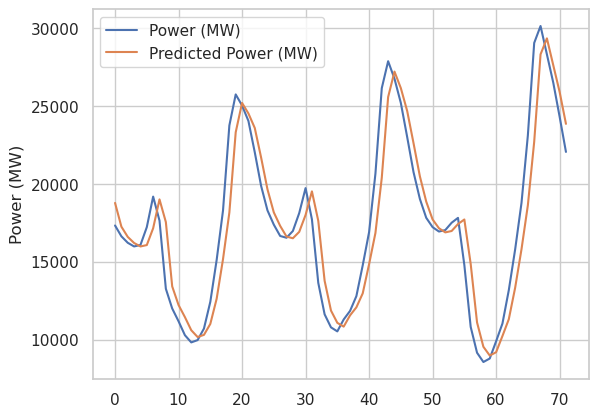

In [27]:
ax = sns.lineplot(x=range(72), y=preds[24:96]['Power (MW)'], label='Power (MW)')
ax = sns.lineplot(ax=ax, x=range(72), y=res_0_1_0.predict()[24:96], label='Predicted Power (MW)')

This model tends to predict slight mean reversion based on the previous sample, which makes sense on average, but is pretty bad in general.

The next model includes only the "seasonal" (a.k.a. daily) term.

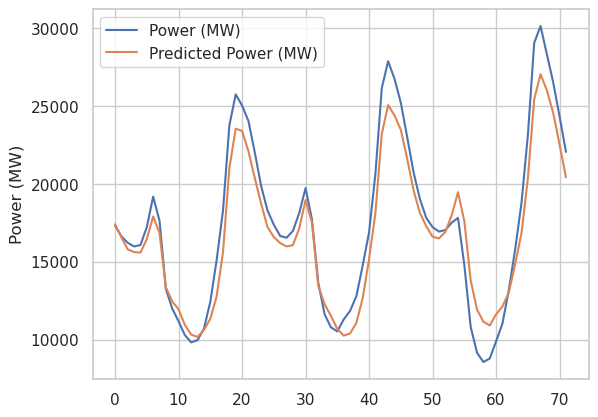

In [28]:
ax = sns.lineplot(x=range(72), y=preds[24:96]['Power (MW)'], label='Power (MW)')
ax = sns.lineplot(ax=ax, x=range(72), y=res_0_0_1.predict()[24:96], label='Predicted Power (MW)')

The prediction of this model is only informed by the value at the same time the day before, so while it doesn't show the lagged behavior that the previous plot does, it is not able to react to any information more recent than 24 hours ago, and consequently is not very good.

Finally, let's plot the residuals of these models as well as the `AR(1)xSAR(1)xVar.L1` model together. We can see that both the green and red curve perform significanty better than the blue and orange curves, showing that having at least 4 terms (not including the constant term) in the model is important. Red and green are quite similar, but we know from the box-plot above that the more complex model (red) has a lower AIC than green. Since it also has more parameters, that must mean its likelihood is higher, and therefore it should have smaller residuals on average.

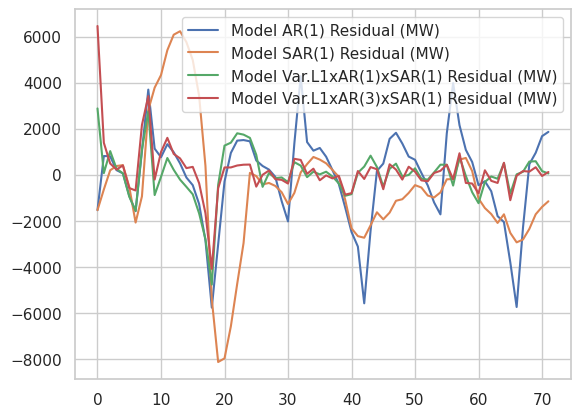

In [23]:
days = 3
ax = sns.lineplot(x=range(days*24), y=res_0_1_0.predict()[:days*24]-preds[:days*24]['Power (MW)'], label='Model AR(1) Residual (MW)')
ax = sns.lineplot(ax=ax, x=range(days*24), y=res_0_0_1.predict()[:days*24]-preds[:days*24]['Power (MW)'], label='Model SAR(1) Residual (MW)')
ax = sns.lineplot(ax=ax, x=range(days*24), y=res_1_1.predict()[:days*24]-preds[:days*24]['Power (MW)'], label='Model Var.L1xAR(1)xSAR(1) Residual (MW)')
ax = sns.lineplot(ax=ax, x=range(days*24), y=res_1_3.predict()[:days*24]-preds[:days*24]['Power (MW)'], label='Model Var.L1xAR(3)xSAR(1) Residual (MW)')

It would be interesting to fit an RNN to this data.